# Rabi experiment

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qubecalib import QubeCalib
from qubecalib.neopulse import (
    Capture,
    Flushleft,
    Flushright,
    RaisedCosFlatTop,
    Rectangle,
    Sequence,
    padding,
)

In [2]:
%matplotlib inline

In [3]:
# load the system settings
qc = QubeCalib("./system_settings.json")

In [4]:
qc.system_config_database._target_settings

{'RQ52': {'frequency': 10.3426},
 'RQ53': {'frequency': 10.51863},
 'RQ54': {'frequency': 10.46727},
 'RQ55': {'frequency': 10.20783},
 'Q52': {'frequency': 7.729161},
 'Q53': {'frequency': 8.817762},
 'Q54': {'frequency': 8.79183},
 'Q55': {'frequency': 7.761116}}

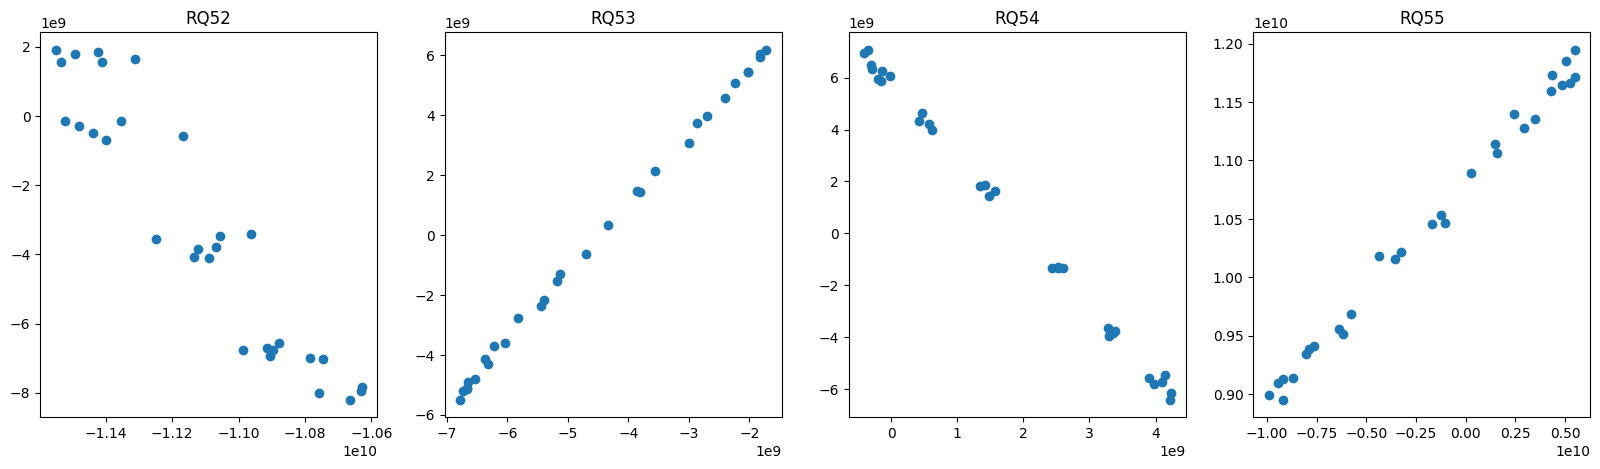

In [5]:
def rabi_sequence(T: int) -> Sequence:
    """
    Rabi sequence with a single target.

    Parameters
    ----------
    T : int
        Duration of the rectangle pulse in ns.

    Returns
    -------
    Sequence
        The rabi sequence.
    """
    control_pulse = Rectangle(duration=T, amplitude=1.0)
    readout_pulse = RaisedCosFlatTop(duration=1024, amplitude=0.1, rise_time=128)
    capture = Capture(duration=3 * 1024)

    with Sequence() as sequence:
        with Flushright():
            control_pulse.scaled(0.0146).target("Q52")
            control_pulse.scaled(0.0238).target("Q53")
            control_pulse.scaled(0.0293).target("Q54")
            control_pulse.scaled(0.0293).target("Q55")
            padding(1024)
        with Flushleft():
            readout_pulse.target("RQ52", "RQ53", "RQ54", "RQ55")
            capture.target("RQ52", "RQ53", "RQ54", "RQ55")
    return sequence


# add rabi sequences to the queue
sweep_range = np.arange(0, 600, 20)
for T in sweep_range:
    qc.add_sequence(rabi_sequence(T))


# execute the sequences
signals = defaultdict(list)
for status, data, config in qc.step_execute(
    repeats=3000,
    interval=150 * 1024,
):
    for target, iqs in data.items():
        iq = iqs[0].squeeze().mean()
        signals[target].append(iq)
    clear_output(True)
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for i, (target, signal) in enumerate(signals.items()):
        axs[i].scatter(np.real(signal), np.imag(signal), label=target)
        axs[i].set_title(target)
    plt.show()

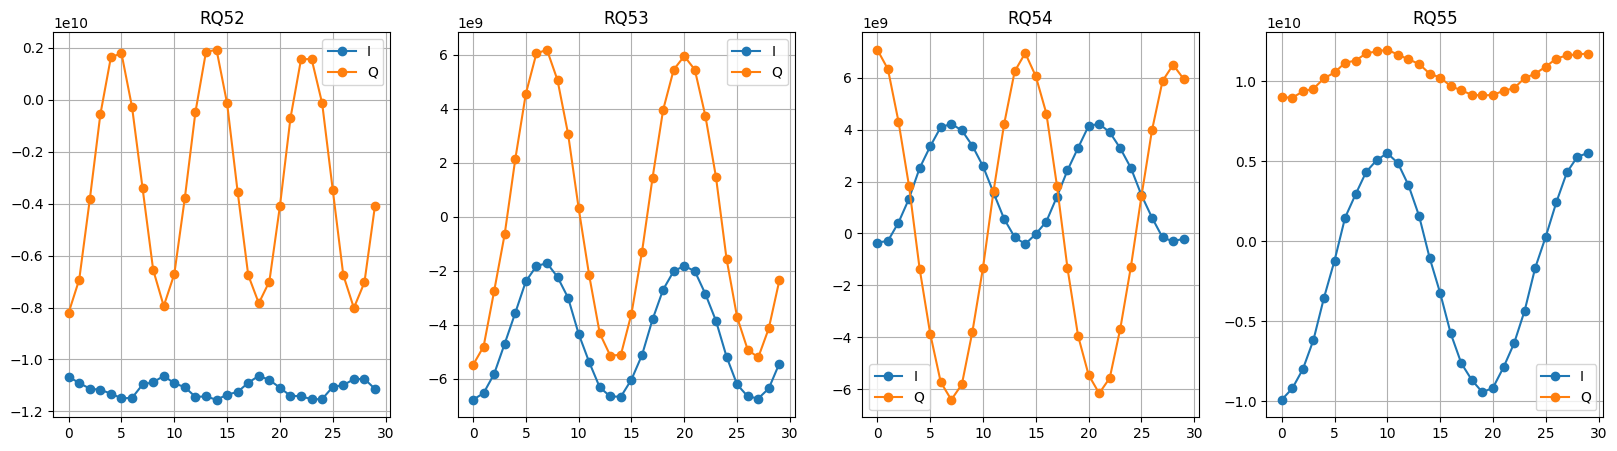

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, (target, signal) in enumerate(signals.items()):
    axs[i].plot(np.real(signal), "o-", label="I")
    axs[i].plot(np.imag(signal), "o-", label="Q")
    axs[i].set_title(target)
    axs[i].legend()
    axs[i].grid()